In [16]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pybedtools as pbt
import math
import pyranges as pr

In [17]:
wd = "/Genomics/kocherlab/bjarnold/Nmel"
macs_peaks_file = f"{wd}/MACS2/Nmel-F1_peaks.narrowPeak" 
# 1. chromosome
# 2. start
# 3. end
# 4. name
# 5. score
# 6. strand
# 7. signalValue - measurement of overall enrichment for the region
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - Point-source called for this peak; -based offset from chromStart

genrich_peaks_file = f"{wd}/genrich_single/Nmel-F1_peaks.narrowPeak"
# 1. chromosome
# 2. chromStart
# 3. chromEnd
# 4. name
# 5. score
# 6. strand
# 7. signalValue - total area under the curve (AUC)
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - summit position (0-based offset from chromStart)

genrich_pileup_file = f"{wd}/genrich_single/Nmel-F1_pileups.txt"

stpeaker_peaks_file = f"{wd}/starrpeaker_test/chr1/Nmel-F1.peak.final.bed"
# Column 1: Chromosome
# Column 2: Start position
# Column 3: End position
# Column 4: Name (peak rank based on score, 1 being the highest rank)
# Column 5: Score (integer value of "100 * fold change", maxed at 1000 per BED format specification)
# Column 6: Strand
# Column 7: Log2 Fold change (normalized output/input ratio, in log2 space)
# Column 8: Input fragment coverage (total fragments across/within replicate(s))
# Column 9: Output fragment coverage (total fragments across/within replicate(s))
# Column 10: -log10 of P-value
# Column 11: -log10 of Q-value (Benjamini-Hochberg False Discovery Rate, FDR)
stpeaker_raw_file = f"{wd}/starrpeaker_test/chr1/Nmel-F1.peak.bed"


From the Genrich [github repo](https://github.com/jsh58/Genrich#controlbackground-pileup-calculation):
The background pileup value is calculated by dividing the total sequence information (sum of read/fragment/interval lengths) in the experimental sample by the calculated genome length. The net control pileup value at a particular genomic position is the maximum of the background pileup value and the pileup of the control sample at that position (if a control sample is specified). Note that control pileups are scaled to match the experimental, based on the total sequence information in each.

Because the control pileup never dips below the background pileup, MACS could be calculating a fold diff that looks very different from the Genrich pileup data, in which local depth pileup that MACS is using is actually quite low but Genrich is using the background pileup value. This is why the MACS fold diff is so high.

As a control, MACS2 [fits a poisson](https://hbctraining.github.io/Intro-to-ChIPseq/lessons/05_peak_calling_macs.html#:~:text=about%20computing%20it.-,Peak%20detection,-After%20MACS%20shifts) to the surrounding 1kb, 5kb, 10kb, and also has a background poisson rate from entire genome. The maximum of these is used as the background rate. 

There may also be a discrepancy between MACS and Genrich results due to the fact that Genrich used a MQ cutoff whereas MACS did not.

In [18]:
# pileup = []
# with open(genrich_pileup_file, 'r') as f:
#     for line in f:
#         # if line.startswith("NMEL_chr_1\t"):
#         line = line.strip().split("\t")
#         pileup.append(line)

pileup_df = pd.read_csv(genrich_pileup_file, sep="\t", header=1)
pileup_df.columns = ["Chromosome", "Start", "End", "experimental", "control", "-log(p)"]
# change experimental, control, and -log(p) columns to numeric
pileup_df[['Start', 'End', 'experimental', 'control', '-log(p)']] = pileup_df[['Start', 'End', 'experimental', 'control', '-log(p)']].apply(pd.to_numeric)

pileup_df['bases'] = pileup_df['End'] - pileup_df['Start']
# pileup_df['experimental_perbase'] = pileup_df['experimental']*pileup_df['bases']
# pileup_df['control_perbase'] = pileup_df['control']*pileup_df['bases']
# print(pileup_df[['experimental_perbase', 'control_perbase']].mean())

pileup_df['fold_diff'] = pileup_df['experimental']/pileup_df['control']
pileup_df['midpoint'] = (pileup_df['End'] - pileup_df['Start'])/2 + pileup_df['Start']
print(len(pileup_df.Chromosome.unique()))
pileup_df


2965


,Chromosome,Start,End,experimental,control,-log(p),bases,fold_diff,midpoint
0,NMEL_unplaced_2528,0,1,672.0,732.211853,0.006488,1,0.917767,0.5
1,NMEL_unplaced_2528,1,2,966.0,1051.150757,0.000749,1,0.918993,1.5
2,NMEL_unplaced_2528,2,3,1210.0,1385.812012,0.000000,1,0.873134,2.5
3,NMEL_unplaced_2528,3,4,1489.0,1619.401123,0.000005,1,0.919476,3.5
4,NMEL_unplaced_2528,4,5,1676.0,1790.100830,0.000065,1,0.936260,4.5
...,...,...,...,...,...,...,...,...,...
11026337,NMEL_unplaced_223,3468,3510,45.0,46.426441,0.331295,42,0.969275,3489.0
11026338,NMEL_unplaced_223,3510,3523,42.0,46.426441,0.263401,13,0.904657,3516.5
11026339,NMEL_unplaced_223,3523,3534,20.0,46.426441,0.005418,11,0.430789,3528.5
11026340,NMEL_unplaced_223,3534,3560,3.0,46.426441,0.000000,26,0.064618,3547.0


In [19]:
macs_df = pd.read_csv(macs_peaks_file, sep="\t", header=None)
macs_df.columns = ["Chromosome", "Start", "End", "name_m", "score_m", "strand_m", "signalValue_m", "pValue_m", "qValue_m", "peak_m"]
macs_df = macs_df.sort_values(by=["Chromosome","Start"])
macs_df["peak_coord_m"] = macs_df["peak_m"] + macs_df["Start"]

genrich_df = pd.read_csv(genrich_peaks_file, sep="\t", header=None)
genrich_df.columns = ["Chromosome", "Start", "End", "name_g", "score_g", "strand_g", "signalValue_g", "pValue_g", "qValue_g", "peak_g"]
genrich_df = genrich_df.sort_values(by=["Chromosome","Start"])
genrich_df["peak_coord_g"] = genrich_df["peak_g"] + genrich_df["Start"]

stpeaker_df = pd.read_csv(stpeaker_peaks_file, sep="\t", header=None)
stpeaker_df.columns = ["Chromosome", "Start", "End", "name_s", "score_s", "strand_s", "log2FC_s", "input_s", "output_s", "pValue_s", "qValue_s"]
stpeaker_df['fold_change'] = 2**stpeaker_df['log2FC_s']
stpeaker_df['midpoint'] = (stpeaker_df['End'] - stpeaker_df['Start']) + stpeaker_df['Start']

stpeaker_raw_df = pd.read_csv(stpeaker_raw_file, sep="\t", header=None)
stpeaker_raw_df['midpoint'] = (stpeaker_raw_df[2] - stpeaker_raw_df[1]) + stpeaker_raw_df[1]
# sns.histplot(genrich_df["signalValue_g"].head(1000), color="blue", )
# plt.axvline(x=400)

In [20]:
# FILTER FOR CHROMOSOME 1
macs_df = macs_df[macs_df["Chromosome"] == "NMEL_chr_1"]
print(len(macs_df))

genrich_df = genrich_df[genrich_df["Chromosome"] == "NMEL_chr_1"]
stpeaker_df = stpeaker_df[stpeaker_df["Chromosome"] == "NMEL_chr_1"]
pileup_df = pileup_df[pileup_df["Chromosome"] == "NMEL_chr_1"]

5263


peaks above q value: 4403
peaks below q value: 860


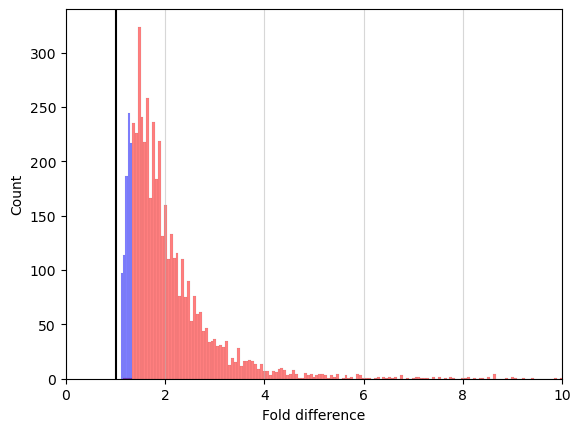

In [21]:
a = macs_df['signalValue_m'][macs_df['qValue_m'] > 1.3]
b = macs_df['signalValue_m'][macs_df['qValue_m'] <= 1.3]
sns.histplot(a, color="red", alpha=0.5, stat='count', bins=1000)
sns.histplot(b, color="blue", alpha=0.5, stat='count', bins=5)
plt.xlim(0,10)
plt.axvline(x=1, color="black")
plt.xlabel("Fold difference")
plt.grid(axis='x', alpha=0.5)
print("peaks above q value:", len(a))
print("peaks below q value:", len(b))

In [22]:
enhancer_density_chr1 = 4403/14215035
enhancer_density_gw = 17139/(300*10**6)
print(1/enhancer_density_chr1)
print(1/enhancer_density_gw)
print("max density of enhancers in human genome:", 1/((1*10**6)/(3*10**9)))

3228.488530547354
17503.93838613688
max density of enhancers in human genome: 3000.0


In [23]:
# apply significance thresholds

# log_qval = 6 # 1.3 corresponds to qvalue of 0.05
macs_df = macs_df[macs_df["qValue_m"] > 1.3] # 1.3 corresponds to pvalue of 0.05
macs_df = macs_df[macs_df["signalValue_m"] > 2] 
print(len(macs_df))

genrich_df = genrich_df[genrich_df["qValue_g"] > 1] # 1.3 corresponds to pvalue of 0.05, 1 corresponds to pvalue of 0.1
# genrich_df = genrich_df[genrich_df["signalValue_g"] > 200]
print(len(genrich_df))

stpeaker_df = stpeaker_df[stpeaker_df["qValue_s"] > 1.3] # 1.3 corresponds to pvalue of 0.05
print(len(stpeaker_df))



1884
2166
186


Text(0.5, 0, 'Peak Width')

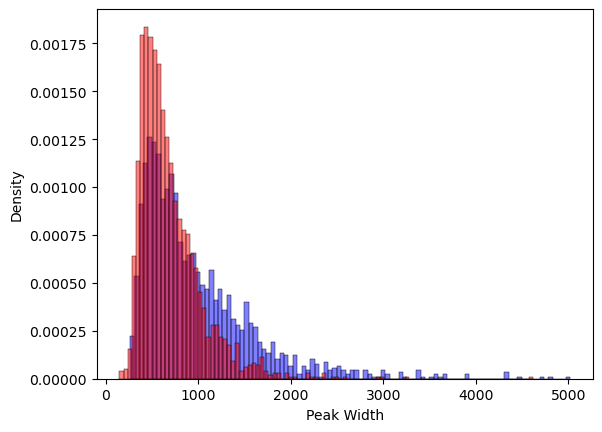

In [24]:
sns.histplot(macs_df['End']-macs_df['Start'], bins=100, color="blue", alpha=0.5, stat='density')
sns.histplot(genrich_df['End']-genrich_df['Start'], bins=100, color="red", alpha=0.5, stat='density')
plt.xlabel("Peak Width")

In [25]:
m = pr.PyRanges(chromosomes=macs_df.Chromosome,
                starts=macs_df.peak_coord_m - 100,
                ends=macs_df.peak_coord_m + 100)
g = pr.PyRanges(chromosomes=genrich_df.Chromosome,
                starts=genrich_df.peak_coord_g - 100,
                ends=genrich_df.peak_coord_g + 100)

o = m.intersect(g)

In [26]:
print('MACS', len(m), 'Genrich', len(g), 'overlap', len(o))
print('overlap/macs', len(o)/len(m), 'overlap/genrich', len(o)/len(g))

MACS 1884 Genrich 2166 overlap 1662
overlap/macs 0.8821656050955414 overlap/genrich 0.7673130193905817


In [27]:
# make new data frame that has coordinates of MACS peaks as Start and End, required by pyranges
macs_summit_df = macs_df[['Chromosome', 'peak_coord_m', 'signalValue_m']]
# make a new column that has value of peak_coord_m + 1
macs_summit_df['peak_coord_m_1'] = macs_summit_df['peak_coord_m'] + 1
macs_summit_df = macs_summit_df[['Chromosome', 'peak_coord_m', 'peak_coord_m_1', 'signalValue_m']]
macs_summit_df.columns = ['Chromosome', 'Start', 'End', 'signalValue_m']

macs_pr = pr.PyRanges(macs_summit_df)
pileup_pr = pr.PyRanges(pileup_df)


/tmp/ipykernel_1306461/1905349515.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macs_summit_df['peak_coord_m_1'] = macs_summit_df['peak_coord_m'] + 1


In [28]:
genrich_fold_diff = np.array(pileup_pr.overlap(macs_pr).fold_diff)
macs_fold_diff = np.array(macs_pr.signalValue_m)

# print(len(genrich_fold_diff), len(macs_fold_diff))
print(np.corrcoef(genrich_fold_diff, macs_fold_diff))


[[1.         0.95291484]
 [0.95291484 1.        ]]


[[1.         0.95291484]
 [0.95291484 1.        ]]
190
1694


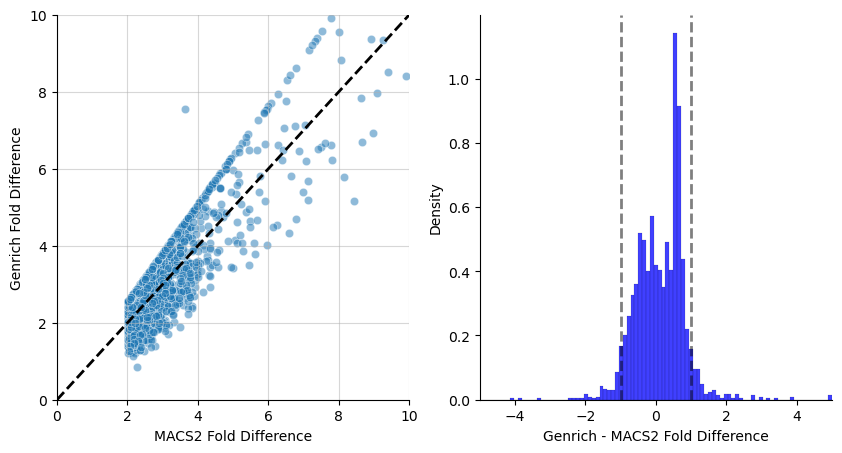

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# sns.scatterplot(x=macs_fold_diff, y=genrich_fold_diff, alpha=0.5, ax=axs[0])
sns.scatterplot(x=macs_fold_diff, y=genrich_fold_diff, alpha=0.5, ax=axs[0])
axs[0].set_xlabel("MACS2 Fold Difference", fontsize=10)
axs[0].set_ylabel("Genrich Fold Difference", fontsize=10)
axs[0].set_xlim(0,10)
axs[0].set_ylim(0,10)
# add diagonal line
axs[0].plot([0, 60], [0, 60], linewidth=2, color='black', linestyle='--')
# add grid lines
axs[0].grid(True, alpha=0.5)

sns.histplot(np.array(genrich_fold_diff)-np.array(macs_fold_diff), color="blue", bins=300, stat='density', ax=axs[1])
axs[1].set_xlim(-5,5)
axs[1].set_xlabel("Genrich - MACS2 Fold Difference", fontsize=10)
axs[1].axvline(x=1, color='black', linestyle='--', alpha=0.5, linewidth=2)
axs[1].axvline(x=-1, color='black', linestyle='--', alpha=0.5, linewidth=2)

sns.despine()   

print(np.corrcoef(genrich_fold_diff, macs_fold_diff))
print(sum(abs(genrich_fold_diff - macs_fold_diff) > 1))
print(sum(abs(genrich_fold_diff - macs_fold_diff) <= 1))

In [30]:
m = pr.PyRanges(chromosomes=macs_df.chromosome,
                starts=macs_df.peak_coord_m - 10,
                ends=macs_df.peak_coord_m + 10)
p = pr.PyRanges(chromosomes=pileup_df.chr,
                starts=pileup_df.midpoint - 10,
                ends=pileup_df.midpoint + 10)

AttributeError: 'DataFrame' object has no attribute 'chromosome'

In [ ]:
print(len(m), len(p), len(m.overlap(p)))

1884 519936 1857
